F24, 94-885 A2, Responsible AI: Principles, Policies, and Practices

(Ungraded Assignment) Week 3 - Explainability and Interpretability: Understanding and Implementing AI Explainability

Ivan Wiryadi (iwiryadi)

---

# Imports and Definitions

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay, roc_curve, roc_auc_score

from lime import lime_tabular
import shap
import matplotlib.pyplot as plt
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preparation

German Credit Metadata: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

The processing steps performed are as follows:
1. Shuffle and split the dataset into training and test set
2. Scale numerical features
3. One-hot encode categorical features
4. Label encode the target features (y)
5. There is no further feature engineering performed

In [2]:
X, y = fetch_openml("credit-g", version=2, as_frame=True, return_X_y=True)

In [3]:
# check for target composition (negative positive classes ratio)
y.value_counts()

class
good    700
bad     300
Name: count, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
category_columns = []
numeric_columns = [] 

for id, type in enumerate(X.dtypes): 
    if type == 'category':
        category_columns.append(X.columns[id])
    else:
        numeric_columns.append(X.columns[id])

In [6]:
# Use OneHotEncoder
ohencoder = OneHotEncoder(sparse_output=False)
ohencoder.fit(X_train[category_columns]) 
c_X_train = X_train.copy().drop(category_columns, axis=1)
c_X_train[ohencoder.get_feature_names_out()] = ohencoder.transform(X_train[category_columns]) 

# Use StandardScaler as specificed in the imports
scaler = StandardScaler()
c_X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns]) 

# Use OHE and StandardScaler for X Test too
c_X_test = X_test.copy().drop(category_columns, axis=1)
c_X_test[ohencoder.get_feature_names_out()] = ohencoder.transform(X_test[category_columns]) 
c_X_test[numeric_columns] = scaler.transform(X_test[numeric_columns]) 

# Use Label Encoder for y
lencoder = LabelEncoder()
c_y_train = lencoder.fit_transform(y_train) 
c_y_test = lencoder.transform(y_test)



In [7]:
# check for label encoder mapping
dict(zip(lencoder.classes_, lencoder.transform(lencoder.classes_)))

{'bad': 0, 'good': 1}

# Modelling

The modelling steps performed are as follows:
1. Train a RandomForestClassifier
2. Evaluate performance

In [8]:
# as specified in the assignment
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

In [9]:
rf_model.fit(c_X_train, c_y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [10]:
y_hat = rf_model.predict(c_X_test)

In [11]:
print(f1_score(c_y_test, y_hat))
print(recall_score(c_y_test, y_hat))
print(precision_score(c_y_test, y_hat))
print(accuracy_score(c_y_test, y_hat))

0.8571428571428571
0.9787234042553191
0.7624309392265194
0.77


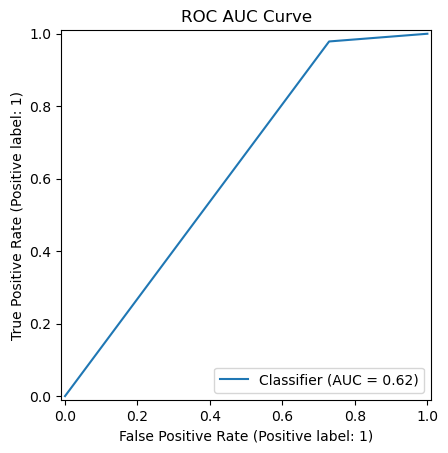

In [12]:
RocCurveDisplay.from_predictions(c_y_test, y_hat)
plt.title("ROC AUC Curve")
plt.show()

In [ ]:
# train a cross validated model for benchmarking result. 
cv_results = cross_validate(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    ),
    c_X_train,  
    c_y_train,  
    cv=5,
    scoring='f1'
)

cv_results

# The single model here seems to be performing well against that cv model, with similar f1 scores (0.857 to 0.820-0.853)

{'fit_time': array([0.16710186, 0.06921005, 0.06947422, 0.06972909, 0.06660795]),
 'score_time': array([0.0043962 , 0.00499201, 0.00488281, 0.00567985, 0.00397325]),
 'test_score': array([0.84920635, 0.82071713, 0.832     , 0.85375494, 0.848     ])}

In [14]:
print(c_X_train.shape)
print(c_y_test.shape)

(800, 61)
(200,)


In [15]:
print(rf_model.classes_)
pred_proba = rf_model.predict_proba(c_X_test)

# Get sample cases for analysis by choosing highest probabilities
print(f"High Class 1 Sample: {np.argmax(pred_proba[:, 1])} ; High Class 0 Sample: {np.argmax(pred_proba[:, 0])}")
print(f"Borderline Class Sample: {np.argmin(np.abs(pred_proba[:, 0] - pred_proba[:, 1]))}")

[0 1]
High Class 1 Sample: 23 ; High Class 0 Sample: 92
Borderline Class Sample: 149


In [16]:
# Store samples for further use in SHAP analysis
good_sample = np.argmax(pred_proba[:, 1])
bad_sample = np.argmax(pred_proba[:, 0])
borderline_sample = np.argmin(np.abs(pred_proba[:, 0] - pred_proba[:, 1]))

# Check whether the samples are accurate predictions
print(np.argmax(pred_proba[good_sample]) == c_y_test[good_sample])
print(np.argmax(pred_proba[bad_sample]) == c_y_test[bad_sample])
print(np.argmax(pred_proba[borderline_sample]) == c_y_test[borderline_sample])


True
True
True


In [17]:
# for checking data
idx = 57
c_X_test[idx:idx+1]

duration  credit_amount  installment_commitment  residence_since  \
10 -0.770774      -0.713177                0.031196         -1.67144   

         age  existing_credits  num_dependents  checking_status_0<=X<200  \
10 -0.925844         -0.710931       -0.409736                       1.0   

    checking_status_<0  checking_status_>=200  ...  housing_own  housing_rent  \
10                 0.0                    0.0  ...          0.0           1.0   

    job_high qualif/self emp/mgmt  job_skilled  job_unemp/unskilled non res  \
10                            0.0          1.0                          0.0   

    job_unskilled resident  own_telephone_none  own_telephone_yes  \
10                     0.0                 1.0                0.0   

    foreign_worker_no  foreign_worker_yes  
10                0.0                 1.0  

[1 rows x 61 columns]

# Explainability Implementations

Perform SHAP analysis toward the model

In [18]:
# compute the SHAP values for the model
explainer = shap.TreeExplainer(rf_model)

In [19]:
shap_values = explainer.shap_values(c_X_test)

In [20]:
rf_model.feature_importances_

array([0.08512436, 0.11049574, 0.03090613, 0.0225361 , 0.0863132 ,
       0.01496787, 0.00357018, 0.01875873, 0.07900003, 0.00577034,
       0.10543724, 0.00958346, 0.03049517, 0.00545749, 0.01485426,
       0.01602742, 0.00655157, 0.00036281, 0.0050452 , 0.00897374,
       0.02280821, 0.00065843, 0.01243587, 0.00104585, 0.        ,
       0.00710736, 0.00453329, 0.00286339, 0.02015168, 0.00259609,
       0.01096321, 0.01209304, 0.00746414, 0.0106411 , 0.01281418,
       0.00503114, 0.01161942, 0.00183095, 0.0045763 , 0.01318259,
       0.00186316, 0.00472453, 0.00828811, 0.0129166 , 0.00688649,
       0.01485986, 0.01369693, 0.01264818, 0.01492925, 0.00153331,
       0.0053078 , 0.02057215, 0.00731311, 0.00969393, 0.01016309,
       0.        , 0.00597713, 0.00932411, 0.01197715, 0.00142363,
       0.00125418])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


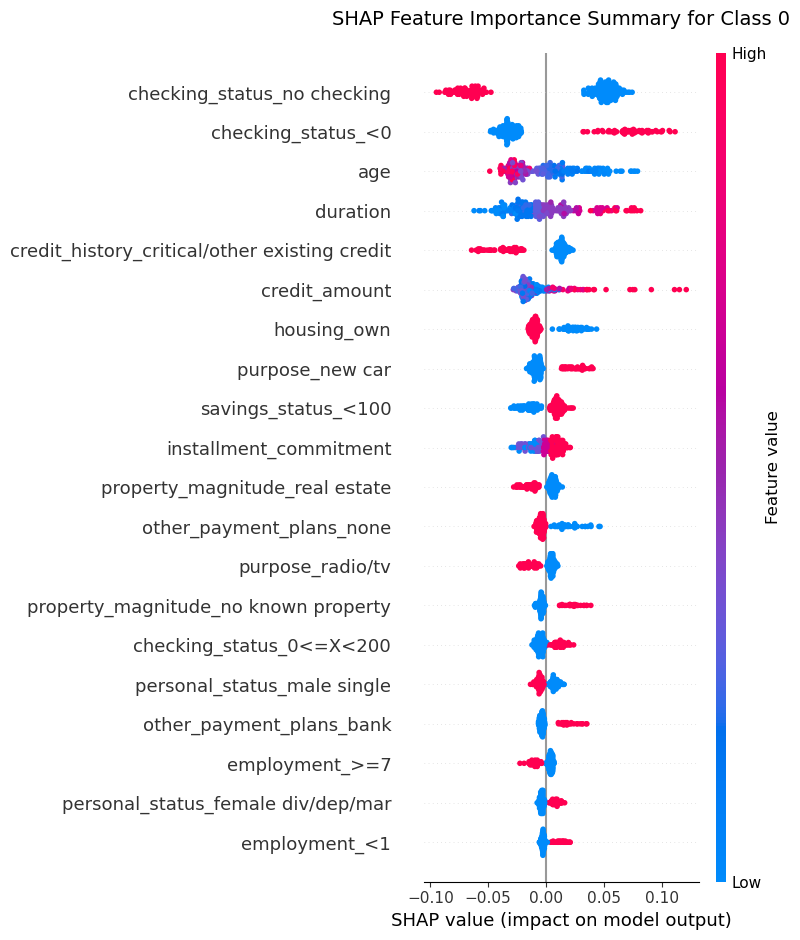

In [21]:
fig_name = "SHAP Feature Importance Summary for Class 0"
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[0], c_X_test, show=False)
plt.title(fig_name, pad=20, fontsize=14)
plt.tight_layout()
plt.savefig(f"../visualizations/{fig_name}", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


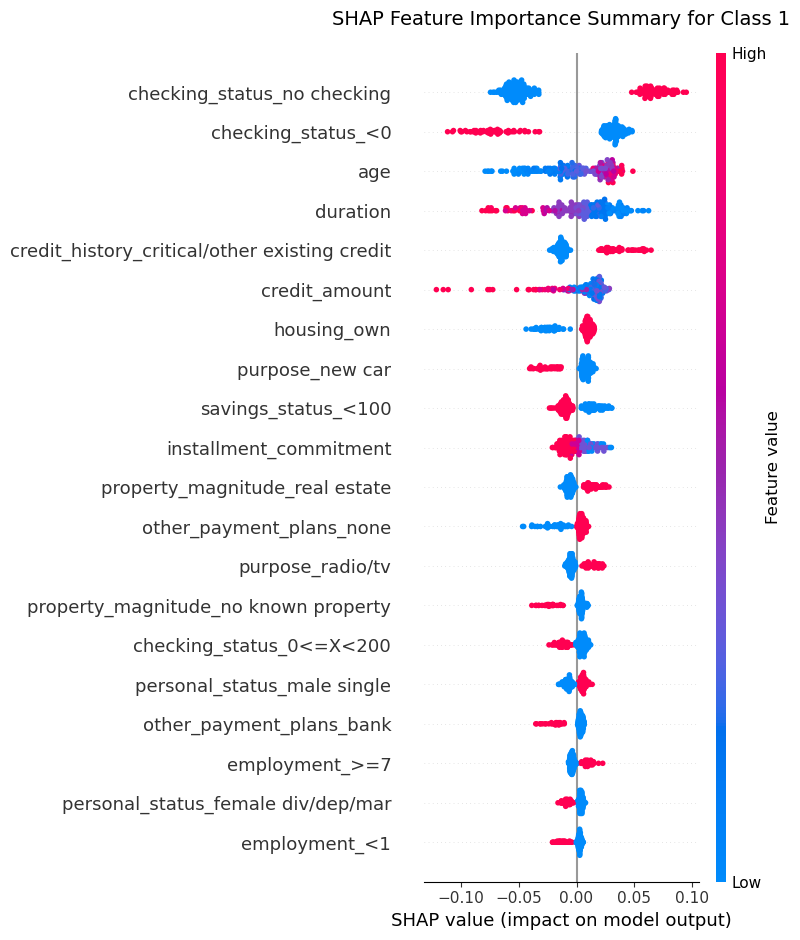

In [22]:
fig_name = "SHAP Feature Importance Summary for Class 1"
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], c_X_test, show=False)
plt.title(fig_name, pad=20, fontsize=14)
plt.tight_layout()
plt.savefig(f"../visualizations/{fig_name}", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [23]:
explain_samples = {
    (good_sample, 0), 
    (good_sample, 1),
    (bad_sample, 0),
    (bad_sample, 1), 
    (borderline_sample, 0),
    (borderline_sample, 1),
}


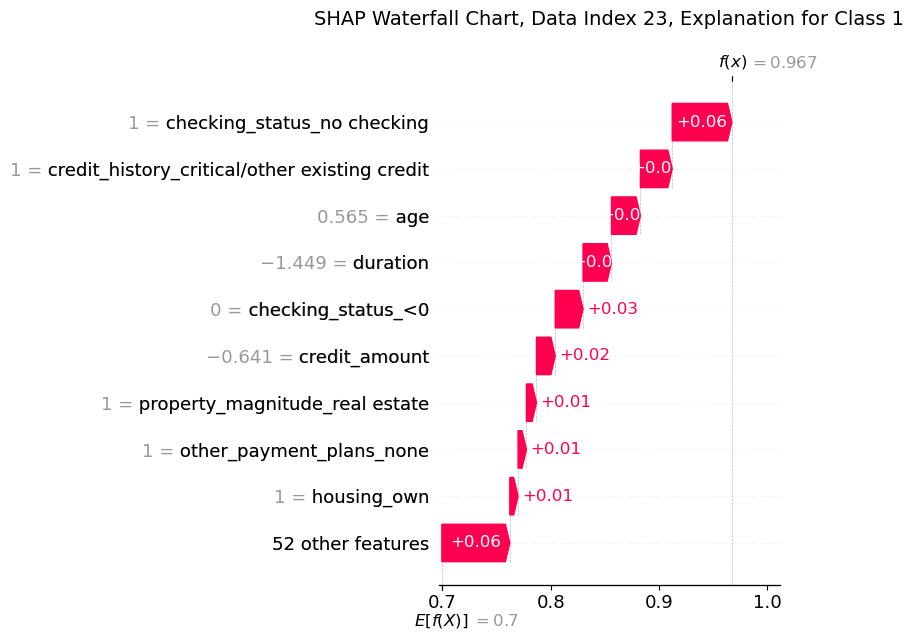

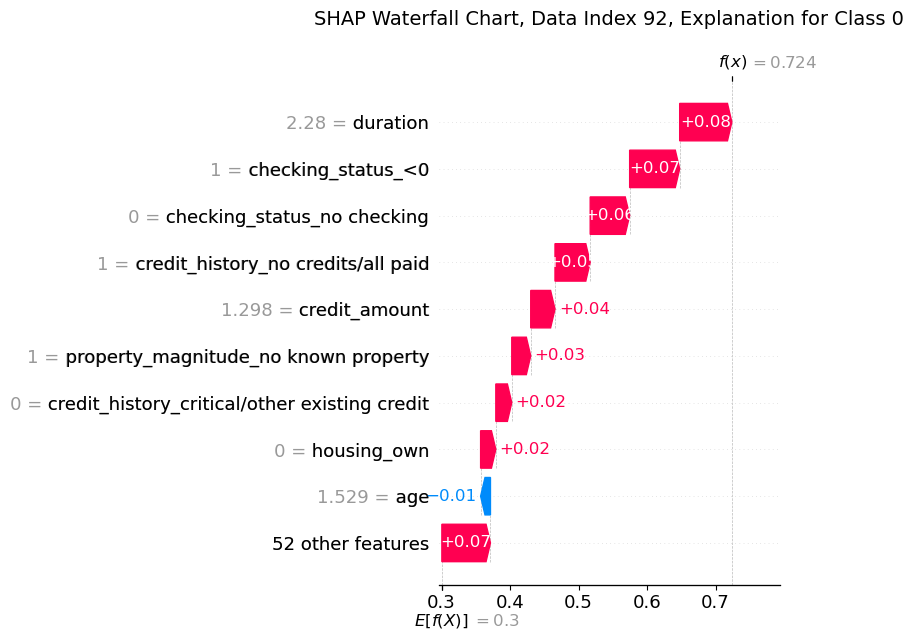

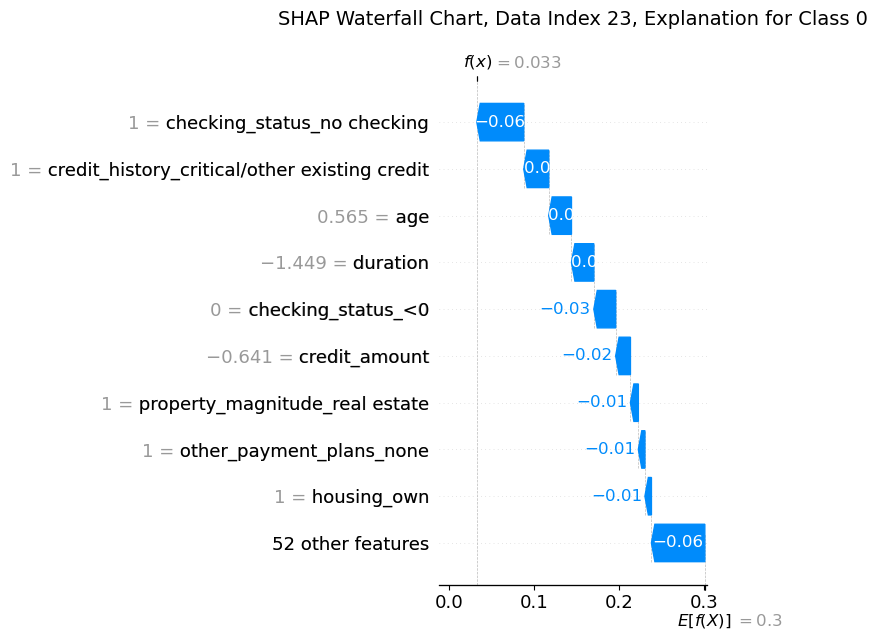

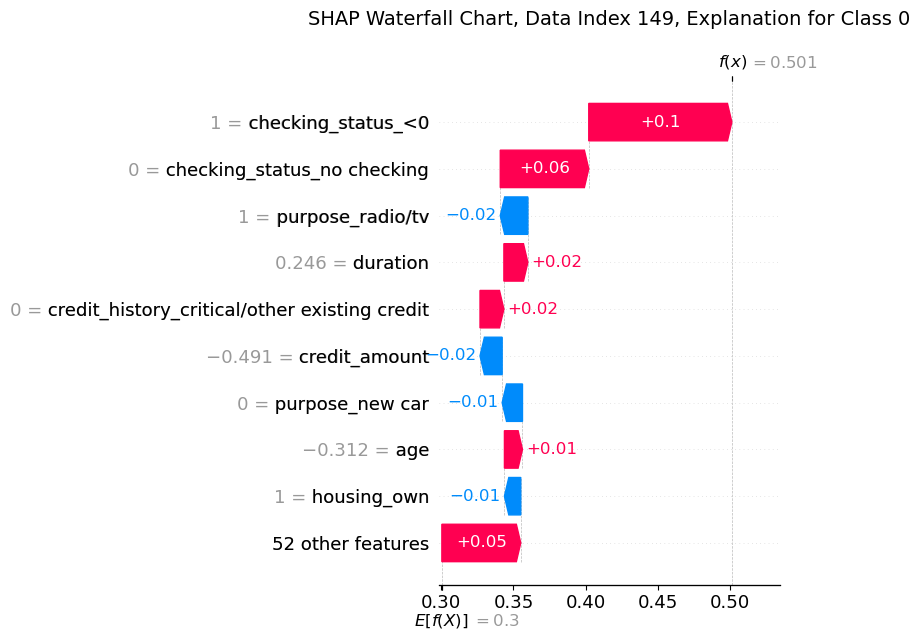

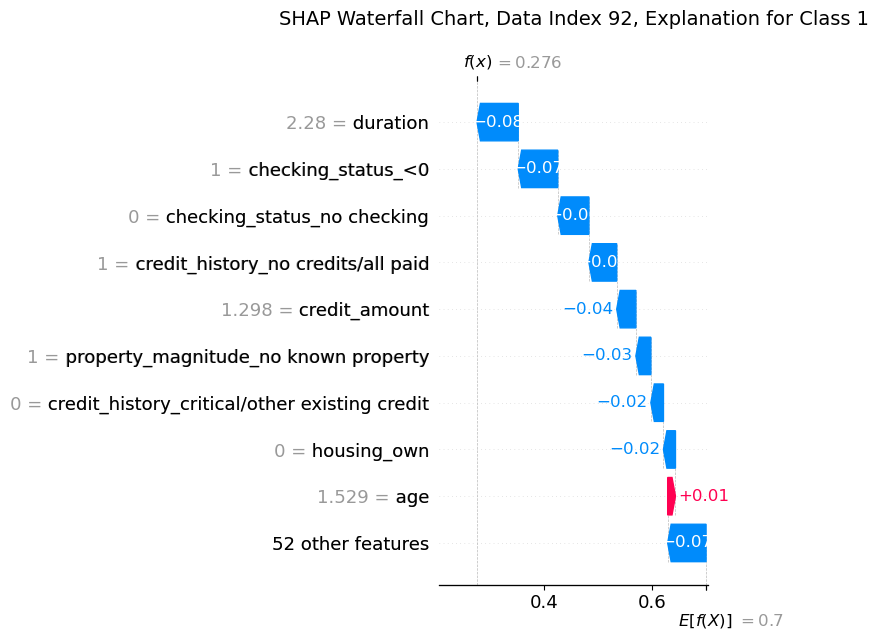

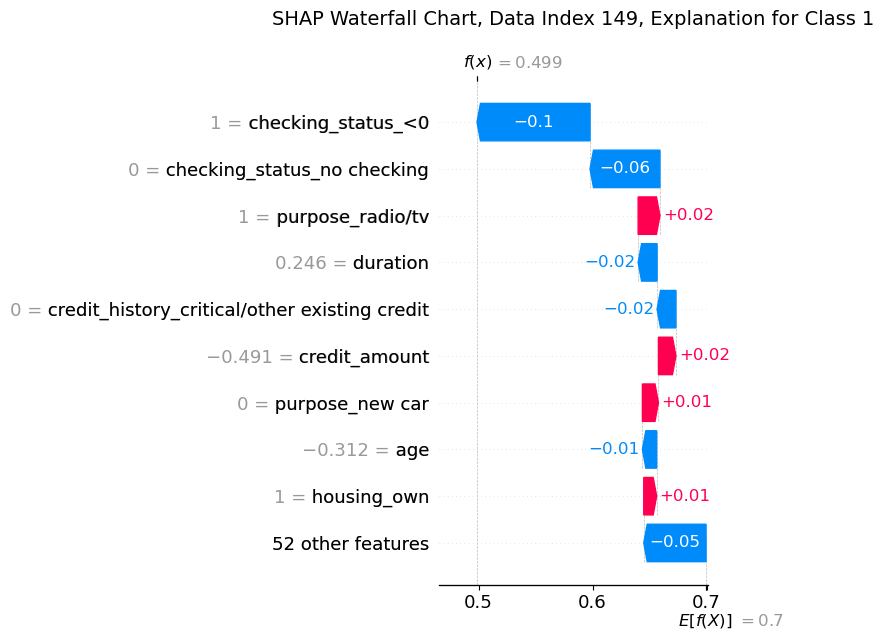

In [24]:
for data_idx, data_class in explain_samples:
    fig_name = f"SHAP Waterfall Chart, Data Index {data_idx}, Explanation for Class {data_class}"
    plt.figure(figsize=(10, 10))

    explanation = shap.Explanation(
            values=shap_values[data_class][data_idx], 
            base_values=explainer.expected_value[data_class],
            data=c_X_test.iloc[data_idx],  
            feature_names=c_X_test.columns
        )

    shap.waterfall_plot(explanation, show=False)

    plt.title(fig_name, pad=20, fontsize=14)
    plt.tight_layout()
    plt.savefig(f"../visualizations/{fig_name}", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [25]:
# Initialize LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=c_X_train.values,     # Training data
    feature_names=c_X_train.columns,    # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification
    mode='classification',              # For classification tasks
    discretize_continuous=True          # Discretize continuous features
)

for instance_idx in {i for i, x in explain_samples}:
    # Explain a single prediction

    exp = lime_explainer.explain_instance(
        c_X_test.iloc[instance_idx].values,    # Instance to explain
        rf_model.predict_proba,         # Prediction function
        num_features=15                 # Number of features to show
    )

    # Visualize the explanation
    exp.show_in_notebook()              # For Jupyter notebooks
    exp.save_to_file(f'../visualizations/LIME Visualization Data Index {instance_idx}.html')

    # Get feature importance as a list
    feature_importance = exp.as_list()

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
